In [2]:
# import the libraries
from __future__ import division
import pandas as pd
import numpy as np

In [3]:
# start an excel sheet to write final data to excel 
writer = pd.ExcelWriter('chronic_heat_shock.xlsx')

In [4]:
# import deseq2 results  
norm_counts_deseq2 = pd.read_csv('chronic_diff_expression')
norm_counts_deseq2 = norm_counts_deseq2.rename(columns={'Unnamed: 0': 'WB_ID'})
norm_counts_deseq2.head(1)

# import this so that we can get gene name and transcript ID for each gene
wormbase_ids = pd.read_csv('c_elegans.PRJNA13758.WS266.geneIDs.txt',names=['numba','WB_ID','common_name','transcript','status','description'])

# import list of introns with their scores so you can get a score for each gene 

scores_for_merging = pd.read_csv('intron_retention_score.csv',index_col=0)

# import all of the reads per replicate 
deseq2_reads = pd.read_csv('normalized_DESEQ2_READS.csv')
deseq2_reads = deseq2_reads.rename(columns={'Unnamed: 0': 'WB_ID'})


In [5]:
norm_counts_deseq2=pd.merge(norm_counts_deseq2,deseq2_reads,on='WB_ID',how='inner')
norm_counts_deseq2.head(1)

,WB_ID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,N2_CTR_1,N2_CTR_3,N2_CTR_4,N2_HS_1,N2_HS_3,N2_HS_4
0,WBGene00015153,60.478255,5.18745,0.775751,6.687004,2.277850e-11,7.215544e-10,1.364508,3.460316,4.89758,238.525939,48.545685,66.075503


In [6]:
scores_for_merging.head(1) # this is the intron_retention_score

,WB_ID,ratio
0,WBGene00000001,0.017265


In [7]:
# give every gene a score by merging with scores for merging 
norm_counts_deseq2 = pd.merge(norm_counts_deseq2, scores_for_merging, how='outer', on='WB_ID')

len(norm_counts_deseq2)

31180

In [8]:
merged = pd.merge(wormbase_ids,norm_counts_deseq2, how='inner', on='WB_ID')
merged.drop(['numba', 'status', 'lfcSE', 'stat', 'pvalue'], inplace=True, axis=1)

In [9]:
merged.head(1)

,WB_ID,common_name,transcript,description,baseMean,log2FoldChange,padj,N2_CTR_1,N2_CTR_3,N2_CTR_4,N2_HS_1,N2_HS_3,N2_HS_4,ratio
0,WBGene00000001,aap-1,Y110A7A.10,protein_coding_gene,754.436329,-0.431524,0.251273,751.161512,937.745596,910.250284,437.297556,731.919551,758.243475,0.017265


In [10]:
# give genes with no common_name a blank string so pandas treats column contents as string
merged.common_name.replace(np.nan, '', regex=True,inplace=True) 

In [11]:
len(merged)

31180

In [12]:
# all things that are up in HS, protein coding and otherwise 

pgate = merged['padj'] < .01
fc_gate = (merged['log2FoldChange']) > 1
bm_gate = merged['baseMean'] > 100
up = merged[pgate & fc_gate & bm_gate ]
len(up)

1366

# PCGS merge pcgs with all genes detected by DESeq2 

In [13]:
# let's look at all protein coding genes without filtering 
merged_pcgs = merged[merged.description.str.contains("protein_coding_gene")]

merged_pcgs.to_csv('all_protein_coding_genes_detected.csv')

# Let's do upgenes first 

In [176]:
# all up protein coding genes
# this is without filtering the introns! 
pgate = merged_pcgs['padj'] < .01
fc_gate = (merged_pcgs['log2FoldChange']) > 1
bm_gate=merged_pcgs['baseMean'] > 100
up = merged_pcgs[pgate & fc_gate & bm_gate ]
len(up)

list_of_up = list(up['WB_ID'])

In [15]:
up.to_csv('up_genes_no_intron_filtering.csv')

# Down Genes DO not filter based off of score

In [16]:
dpgate = merged_pcgs['padj'] < .01
dfc_gate = (merged_pcgs['log2FoldChange']) < - 1
dbm_gate = merged_pcgs['baseMean'] > 100
down = merged_pcgs[dpgate & dfc_gate & dbm_gate ]
len(down)

800

In [17]:
# save down genes to csv, and a list of them to txt
down.to_csv('genes_down_in_heat_shock.csv',index=None) # save as a csv 
list_of_down=down.WB_ID 
list_of_down.to_csv('list_of_down.txt',sep='\t',index=None)

/home/wschrein/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


In [185]:
hsp = []
for i in merged['common_name']:
    if "hsp" in i:
        hsp.append("hsp")
    else:
        hsp.append("no")

merged['hsp'] = hsp

In [186]:
bad_genes = pd.read_table('todos_los_genes_malas.txt')

/home/wschrein/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [187]:
bad_genes_list = list(bad_genes['WB_ID'])

In [188]:
bad_gene = []
for index, row in merged.iterrows():
    if row.WB_ID in bad_genes_list:
        bad_gene.append('yes')
    else:
        bad_gene.append("no")
        
merged['bad_gene'] = bad_gene


In [189]:
up_in_hs = []
for index, row in merged.iterrows():
    if row.WB_ID in list_of_up:
       up_in_hs.append('yes')
    else:
        up_in_hs.append("no")
        
merged['up'] = up_in_hs



In [252]:
srt_bad = ['srt-42']

In [255]:
cat = []
for index, row in merged.iterrows():
    if row.common_name in srt_bad:
        cat.append('yes')
    else:
        cat.append("no")
        
merged['cat'] = cat



In [256]:
merged[merged.cat=='yes']

,WB_ID,common_name,transcript,description,baseMean,log2FoldChange,padj,N2_CTR_1,N2_CTR_3,N2_CTR_4,N2_HS_1,N2_HS_3,N2_HS_4,ratio,hsp,bad_gene,up,cat
17832,WBGene00021599,srt-42,Y46H3A.1,protein_coding_gene,4385.506439,11.889568,2.717188e-29,0.0,4.844442,2.098963,13816.683586,8379.732005,4109.679636,0.616047,no,yes,yes,yes


# Make file for graphing that contains the normalized reads 

In [257]:
merged.to_csv('merged_hsp_labeled.csv')

In [258]:
import rpy2

In [259]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [260]:
%%R
library("ggplot2")

df <- read.csv('merged_hsp_labeled.csv')
head(df)

  X          WB_ID common_name transcript         description  baseMean
1 0 WBGene00000001       aap-1 Y110A7A.10 protein_coding_gene 754.43633
2 1 WBGene00000002       aat-1    F27C8.1 protein_coding_gene 180.33051
3 2 WBGene00000003       aat-2    F07C3.7 protein_coding_gene 172.32816
4 3 WBGene00000004       aat-3    F52H2.2 protein_coding_gene  73.37688
5 4 WBGene00000005       aat-4  T13A10.10 protein_coding_gene 213.76577
6 5 WBGene00000006       aat-5    C55C2.5 protein_coding_gene 182.17144
  log2FoldChange         padj  N2_CTR_1  N2_CTR_3  N2_CTR_4   N2_HS_1   N2_HS_3
1    -0.43152363 2.512731e-01 751.16151 937.74560 910.25028 437.29756 731.91955
2     2.17344880 5.591004e-05  66.86088  48.44442  81.15990 519.54788 169.90990
3    -0.50273045 3.138148e-01 258.57422 141.18089 205.69837 176.83820 153.10562
4    -0.06317415 9.248257e-01  74.36567  68.51425  82.55921  93.21703  52.27997
5     0.19381732 7.450145e-01 182.16178 211.77133 204.99872 356.41807 134.43420
6     0.04318494

In [261]:
%%R

df$neg_log_padg <- -log(df$padj)


df$l2_ctr_fc <- log2(((df$N2_CTR_1 + df$N2_CTR_3 + df$N2_CTR_4)/3))

df$l2_hs_fc <- log2(((df$N2_HS_1 + df$N2_HS_3 + df$N2_HS_4)/3))

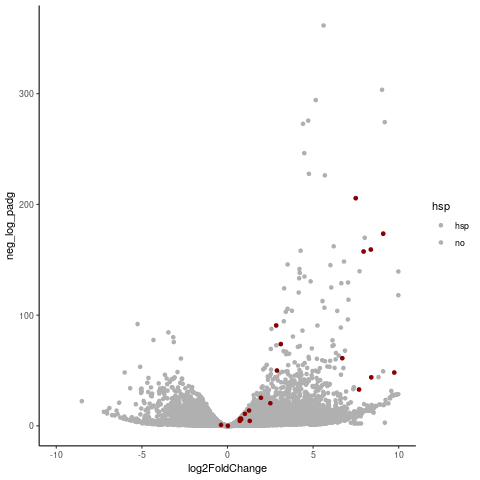

In [262]:
%%R

z <- ggplot(df,aes( log2FoldChange,neg_log_padg,)) + geom_point(aes(colour=hsp)) #+geom_abline(slope = 1)

z <- z + scale_color_manual(breaks = c("hsp", "no"),
                       values=c("grey69", "grey69"))

z <- z + xlim(-10,10) + theme_classic()

z <- z + geom_point(data=subset(df,hsp=="hsp"),stat="identity",color='darkred')



z



In [283]:
%%R

z <- ggplot(df,aes(l2_ctr_fc,l2_hs_fc,)) + geom_point(aes(colour=hsp)) +geom_abline(slope = 1, linetype = 2, intercept = 1) 

z <- z +geom_abline(slope = 1, linetype = 2, intercept = -1)

z <- z + scale_color_manual(breaks = c("hsp", "no"),
                       values=c("grey69", "grey69"))

z <- z + theme_classic() + xlim(0,20) + ylim(0,20)

z <- z + geom_point(data=subset(df,hsp=="hsp"),stat="identity",color='darkred')



z

ggsave('hsp_graph.png')

/home/wschrein/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Saving 6.67 x 6.67 in image

  warnings.warn(x, RRuntimeWarning)


In [286]:
%%R

z <- ggplot(df,aes(l2_ctr_fc,l2_hs_fc,)) + geom_point(aes(colour=bad_gene)) +geom_abline(slope = 1, linetype=2, intercept =1)

z <- z +geom_abline(slope = 1, linetype=2, intercept =-1)

z <- z + scale_color_manual(breaks = c("yes", "no"),
                       values=c("grey69", "grey69"))

z <- z + theme_classic() 

z <- z + geom_point(data=subset(df,bad_gene=="yes"),stat="identity",color='darkblue')



z
ggsave("bad_boys.png")

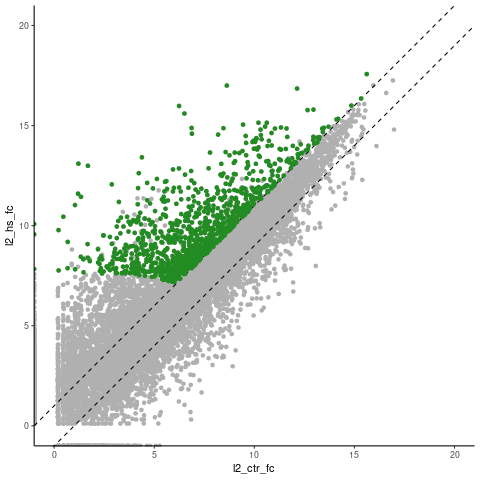

In [287]:
%%R

z <- ggplot(df,aes(l2_ctr_fc,l2_hs_fc,)) + geom_point(aes(colour=up)) +geom_abline(slope = 1, linetype = 2, intercept = 1) 

z <- z +geom_abline(slope = 1, linetype = 2, intercept = -1)

z <- z + scale_color_manual(breaks = c("hsp", "up"),
                       values=c("grey69", "grey69"))

z <- z + theme_classic() + xlim(0,20) + ylim(0,20)

z <- z + geom_point(data=subset(df,up=="yes"),stat="identity",color='forestgreen')


ggsave("sig_up.png")
z

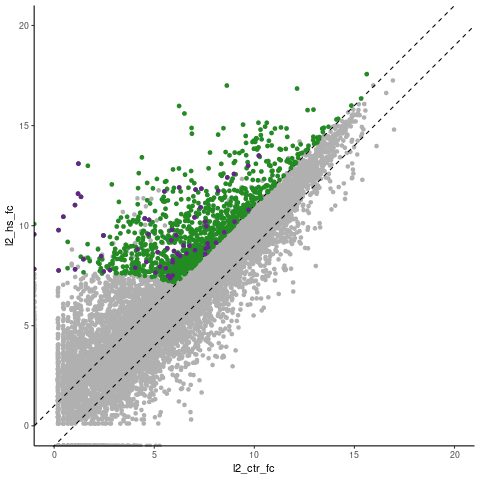

In [266]:
%%R

z <- ggplot(df,aes(l2_ctr_fc,l2_hs_fc,)) + geom_point(aes(colour=up)) +geom_abline(slope = 1, linetype = 2, intercept = 1) 

z <- z +geom_abline(slope = 1, linetype = 2, intercept = -1)

z <- z + scale_color_manual(breaks = c("hsp", "up"),
                       values=c("grey69", "grey69"))

z <- z + theme_classic() + xlim(0,20) + ylim(0,20)

z <- z + geom_point(data=subset(df,up=="yes"),stat="identity",color='forestgreen')


z <- z + geom_point(data=subset(df,bad_gene=="yes"),stat="identity",color='darkorchid4')


z



In [284]:
%%R

z <- ggplot(df,aes(l2_ctr_fc,l2_hs_fc,)) + geom_point(aes(colour=cat)) +geom_abline(slope = 1, linetype=2, intercept =1)

z <- z +geom_abline(slope = 1, linetype=2, intercept =-1)

z <- z + scale_color_manual(breaks = c("yes", "no"),
                       values=c("grey69", "grey69"))

z <- z + theme_classic() 

z <- z + geom_point(data=subset(df,cat=="yes"),stat="identity",color='darkorchid4')



z

ggsave("srt-42.png")

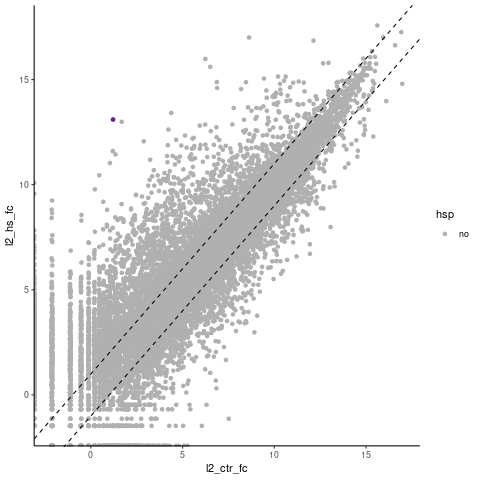

In [282]:
%%R

z <- ggplot(df,aes(l2_ctr_fc,l2_hs_fc,)) + geom_point(aes(colour=hsp)) +geom_abline(slope = 1, linetype=2, intercept =1)

z <- z +geom_abline(slope = 1, linetype=2, intercept =-1)

z <- z + scale_color_manual(breaks = c("yes", "no"),
                       values=c("grey69", "grey69"))


z <- z + geom_point(data=subset(df,hsp=="yes"),stat="identity",color='darkred')

z <- z + geom_point(data=subset(df,cat=="yes"),stat="identity",color='darkorchid4')


z <- z + theme_classic() 

z

In [268]:
malo_df = merged[merged.bad_gene=='yes']

In [269]:
malo_df.sort_values('log2FoldChange',ascending=False)

,WB_ID,common_name,transcript,description,baseMean,log2FoldChange,padj,N2_CTR_1,N2_CTR_3,N2_CTR_4,N2_HS_1,N2_HS_3,N2_HS_4,ratio,hsp,bad_gene,up,cat
14694,WBGene00018020,,F33H12.6,protein_coding_gene,379.621139,12.545014,2.478781e-22,0.000000,0.000000,0.000000,973.295500,498.526837,805.904494,0.269661,no,yes,yes,no
17832,WBGene00021599,srt-42,Y46H3A.1,protein_coding_gene,4385.506439,11.889568,2.717188e-29,0.000000,4.844442,2.098963,13816.683586,8379.732005,4109.679636,0.616047,no,yes,yes,yes
15683,WBGene00019136,,F59H6.5,protein_coding_gene,303.419905,11.260202,4.911565e-18,0.000000,0.692063,0.000000,563.414719,433.176877,823.235773,0.017735,no,yes,yes,no
7236,WBGene00009585,cal-7,F40F9.8,protein_coding_gene,225.384368,10.828956,3.101465e-16,0.682254,0.000000,0.000000,684.048528,369.694059,297.881365,0.754826,no,yes,yes,no
25630,WBGene00194744,,Y38H6C.25,protein_coding_gene,114.105834,10.812442,1.854933e-15,0.000000,0.000000,0.000000,130.229680,190.448455,363.956868,0.451969,no,yes,yes,no
3492,WBGene00005145,srd-68,F09C6.7,protein_coding_gene,200.874490,10.663394,7.736937e-16,0.000000,0.692063,0.000000,596.314849,300.609816,307.630210,1.003734,no,yes,yes,no
9976,WBGene00012621,,Y38H6C.8,protein_coding_gene,1552.954328,10.398738,4.095886e-66,4.775777,1.384126,0.699654,2349.617588,2253.640047,4707.608777,0.689981,no,yes,yes,no
18454,WBGene00022315,,Y81B9A.1,protein_coding_gene,1392.386208,10.100623,5.608066e-72,3.411269,0.692063,3.498272,3913.744582,1956.764515,2476.206549,0.025432,no,yes,yes,no
10451,WBGene00013154,,Y53F4B.7,protein_coding_gene,697.929483,9.979184,5.908939e-52,2.046762,2.076190,0.000000,1342.051119,1357.412025,1483.990802,0.002148,no,yes,yes,no
5924,WBGene00008144,gasr-8,C47E8.6,protein_coding_gene,1045.567612,9.978377,3.046261e-61,4.093523,2.076190,0.000000,2540.164172,2360.067124,1367.004665,0.474011,no,yes,yes,no
